# Question classification on the Text REtrieval Conference (TREC) Question Classification dataset.
**Nicola Carrassi matr. 0001037813 nicola.carrassi@studio.unibo.it**

<br>

In this project, the topic of Question Classification on the TREC dataset will be explored. A range of techniques will be used to tackle the problem of text classification, including machine learning algorithms, Transformer-based methods, and a Graph Neural Network approach. The report will cover the following steps:

1. Preparation of the dataset
2. Data analysis
3. Machine learning classification techniques on the latent space
4. Transformer-based techniques 
5. Graph Neural Network approach
6. Final conclusions



## Introduction

The Text REtrieval Conference (TREC) Question Classification dataset consists of 5,500 labeled questions in the training set and 500 additional questions in the test set. The dataset contains 6 broad categories and 50 more specific categories. <br>
To evaluate the performance of our approaches against state-of-the-art methods, we will evaluate based on the broad categories (*coarse_label*) instead of the fine categories. <br>

The data is collected from four sources:

- 4500 English questions published by USC
- Approximately 500 manually constructed questions for a few rare classes
- 894 questions from TREC 8 and TREC 9 
- 500 questions from TREC 10, which serve as the test set


A review of the dataset page on PapersWithCode shows that the current state-of-the-art is achieved through fine-tuning a BERT-base model on the dataset.

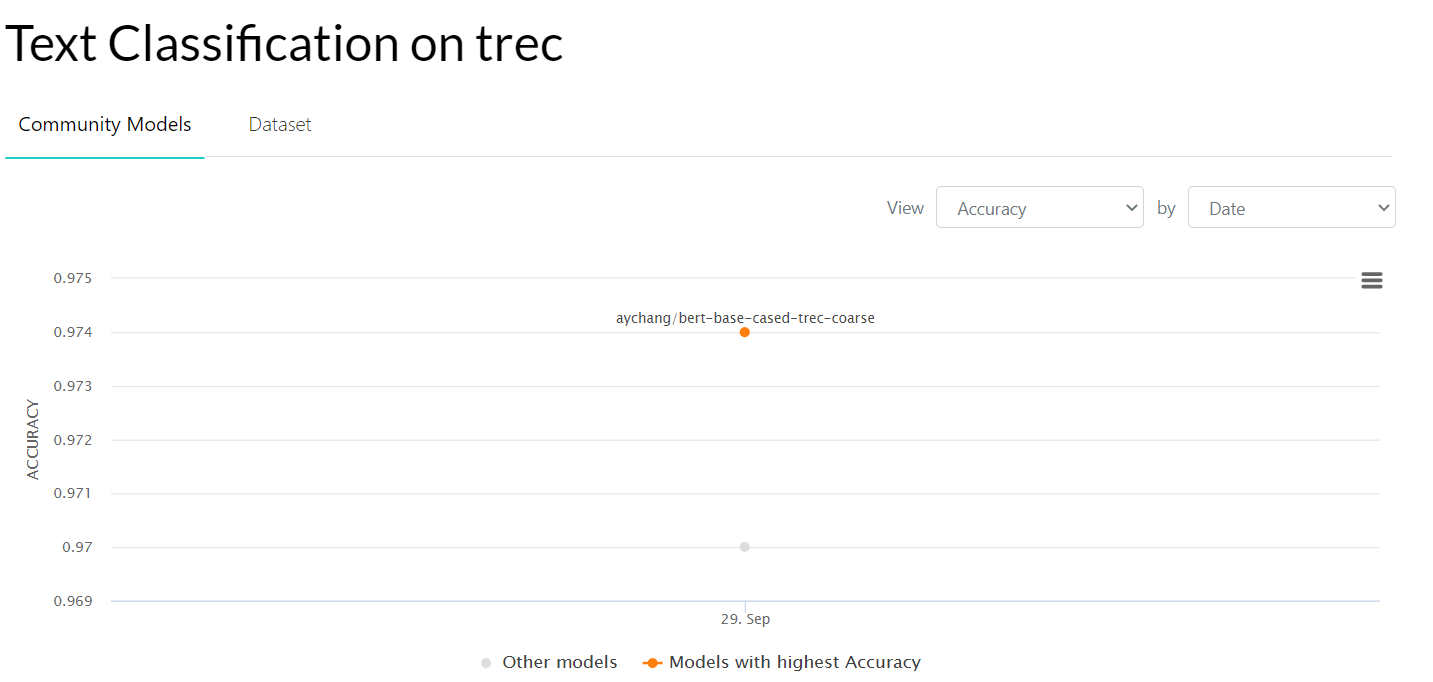 




The 6 broad classes we will use are represented as integer values and they are the following:

- 0: Abbreviation (ABBR)
- 1: Entity (ENTY)
- 2: Description and abstract concept (DESC)
- 3: Human being (HUM)
- 4: Location (LOC)
- 5: Numeric value (NUM)


## Libreries Import

First of all we install and import all the libraries that will be used for the project, then we mount the drive and download the modules from nltk.

In [ ]:
%%capture
!pip install transformers
!pip install datasets
!pip install spacy
!pip install contractions
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

In [ ]:
from google.colab import drive, files

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

import nltk
import spacy
import contractions
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
from datasets import Features, Value, Sequence


import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from torch.nn import Linear
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool



In [ ]:
PROJECT_PATH = '/content/gdrive/MyDrive/Unibo/NLP_ProjectWork'
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

drive.mount('/content/gdrive', force_remount=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/gdrive


## Reproducibility

To ensure accurate evaluation, reproducibility is crucial. For this reason, a random seed of 42 has been set as the standard for all sources of randomness throughout the project.

In [ ]:
RANDOM_SEED = 42

def set_reproducibility(seed: int):
    """
    Set the same random seed to different sources of randomness

    :param seed: random seed
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(RANDOM_SEED)

## Dataset loading and preparation

We download the training and test splits of the dataset and remove the column containing the fine category, as it will not be used in this project.

In [ ]:
hf_train = load_dataset('trec', split='train')
hf_test = load_dataset('trec', split='test')

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2. Subsequent calls will reuse this data.


In [ ]:
# Convert the dataframes into pandas dataframes

train_df = pd.DataFrame(hf_train)
test_df = pd.DataFrame(hf_test)

In [ ]:
# Drop fine_label column which will not be used

train_df.drop(['fine_label'], axis=1, inplace=True)
test_df.drop(['fine_label'], axis=1, inplace=True)

In [ ]:
train_df.head()

,text,coarse_label
0,How did serfdom develop in and then leave Russ...,2
1,What films featured the character Popeye Doyle ?,1
2,How can I find a list of celebrities ' real na...,2
3,What fowl grabs the spotlight after the Chines...,1
4,What is the full form of .com ?,0


Since a validation set was not provided, we will split the training set into two: 80% will be used as the training set and the remaining 20% will serve as the validation set.

In [ ]:
# Split the training set into train and validation set
tmp = train_df.copy()

train_df = train_df.sample(frac=0.8,random_state=RANDOM_SEED)
val_df = tmp.drop(train_df.index)

## Data Analysis

The following chapter will focus on the analysis of the data. In this section, we will explore the characteristics of the dataset and gain a deeper understanding of the data we will be working with. <br>
This step is crucial as it provides a foundation for the rest of the project and helps inform our subsequent decision-making processes.
<br><br>

The first operation is the inspection the dimensions of the three sets after the splitting

In [ ]:
print("The train dataframe has: {0} rows".format(len(train_df)))
print("The validation dataframe has: {0} rows".format(len(val_df)))
print("The test dataframe has: {0} rows".format(len(test_df)))

The train dataframe has: 4362 rows
The validation dataframe has: 1090 rows
The test dataframe has: 500 rows


Now we inspect the distribution of classes in the training set. This involves counting the number of instances for each class and plotting their distribution. The goal of this inspection is to determine if there are any imbalances in the data, which could potentially affect the performance of our models

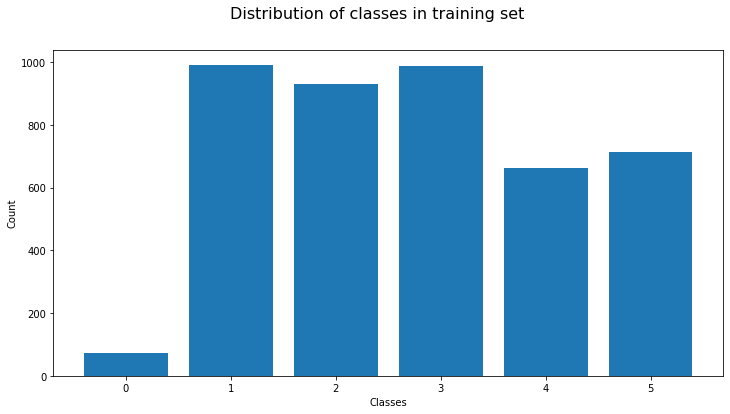

In [ ]:
val_counts = train_df['coarse_label'].value_counts()
labels = val_counts.index

frequencies = [val_counts[label] for label in labels]

fig = plt.figure(figsize=(12,6))
fig.suptitle("Distribution of classes in training set", fontsize=16)
bar = plt.bar(labels, frequencies)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

Our analysis revealed that there are imbalanced classes, with the class labeled 0 having fewer instances compared to the other classes. Despite these imbalances, we chose not to perform any oversampling or undersampling techniques in order to balance the data. 

Following our inspection of class distribution, we examine the lengths of the sentences in the dataset. This analysis provides insight into the average length of the questions and helps us to determine if there are any outliers or extreme values. By understanding the distribution of sentence lengths, we can ensure that our models are able to handle the range of inputs they will encounter during evaluation. <br>Additionally, this information can inform our preprocessing decisions, such as selecting appropriate padding lengths or truncating excessively long sentences.

In [ ]:
sentences_len = np.array([len(line.split()) for line in train_df['text'].to_numpy()])

print("The shortest sentence in the dataset has {} words ".format(np.min(sentences_len)))
print("The longest sentence in the dataset has {} words ".format(np.max(sentences_len)))
print("The average length of sentences in the dataset is ", int(np.round(np.mean(sentences_len))))

The shortest sentence in the dataset has 3 words 
The longest sentence in the dataset has 37 words 
The average length of sentences in the dataset is  10


Lastly we create a word cloud of the training set after removing stopwords. This visualization provides a quick overview of the most frequently occurring words in the data and can give us insight into the topic and content of the questions.

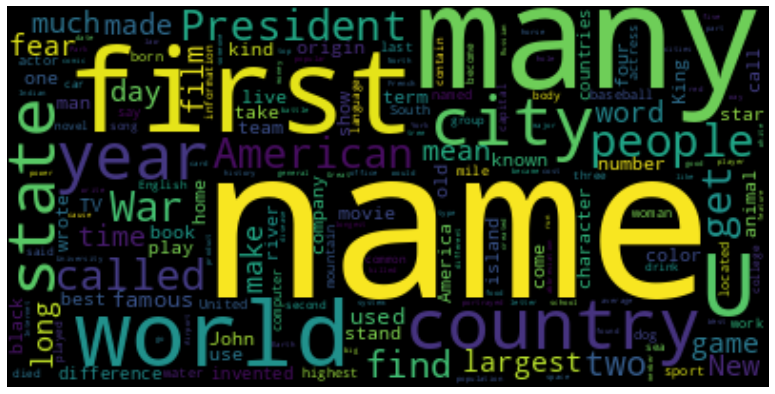

In [ ]:
text = " ".join(text for text in train_df['text'])
stopw = stopwords.words('english')

wordcloud = WordCloud(collocations = False, stopwords=stopw, background_color = 'black').generate(text)


plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Latent Semantic Analysis - LSA

LSA is a dimensionality reduction method that represents text data as a lower-dimensional representation in a vector space, known as the Latent Semantic Space. This representation captures the meaning of the text by preserving the relationships between words and documents.

By applying LSA to the TREC dataset, we aim to learn a compact representation of the text data that can be used as input to a classifier. This approach has been widely used in text classification and has been shown to be effective in many applications. <br>

In this section, we will describe the process of applying LSA to the TREC dataset and use it as a input to different classifiers.

### Preprocessing for LSA

Before applying Latent Semantic Analysis (LSA), it is essential to perform some preprocessing on the text data. This is because the quality of the results heavily depends on the preprocessing steps applied to the text data. <br>
The preprocessing pipeline applied to the TREC dataset includes:
- cleaning 
- tokenizing 
- lemmatizing 
- removal of stopwords.

By performing these preprocessing steps, we can improve the quality of the LSA results by removing noise and reducing the dimensionality of the text data. This leads to a more accurate and effective representation of the text in the Latent Semantic Space, which can improve the performance of text classification models.


In [ ]:
x_train = train_df['text']
y_train = train_df['coarse_label'].to_list()

x_val = val_df['text']
y_val = val_df['coarse_label'].to_list()

x_test = test_df['text']
y_test = test_df['coarse_label'].to_list()

In [ ]:
# We load the lemmatizer

lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
stopw = set(stopw)

In [ ]:
# Definition of the functions which allow to convert the text to lowecase,
# remove contractions and stopwords, tokenize and lemmatize the text 

def to_lower(s: str) -> str:
  """
  Converts a string to lowecase

  @param s: string to convert

  @return lowercase string
  """
  return s.lower()

def remove_contractions(s: str) -> str :
  """
  Removes the contraction from a string

  @param s: string to convert

  @return String with contractions expanded
  """
  return contractions.fix(s)

def remove_stopwords(s: str) -> str:
  """
  Removes the stopwords from a string

  @param s: string to convert

  @return String without stopwords
  """
  return " ".join([word for word in s.split() if not word in stopw])


def lemmatize_sentence(s: str) -> str:
  """
  Lemmatizes a string

  @param s: string to convert

  @return Lemmatized string
  """

  tmp = lemmatizer(s)
  return ' '.join([token.lemma_ for token in tmp])


def apply_pipeline(s: str, pipeline) -> str:
  """
  Applies a pipeline of functions to a string

  @param s: string to convert
  @param pipeline: pipeline of functions to apply

  @return string after all the functions in the pipeline have been applied
  """
  for f in pipeline:
    s = f(s)
  return s

The preprocessing pipeline for the TREC dataset includes several steps to clean and prepare the text data for Latent Semantic Analysis (LSA). The steps are as follows:

1. **Convert to lowercase**: All the text data will be converted to lowercase to reduce the dimensionality of the text data and ensure that words with different capitalization are treated as the same word.

2. **Remove contractions**: Contractions are common in natural language text and can introduce ambiguity into the text data. Removing contractions can help to improve the quality of data.

3. **Lemmatization**: This step involves reducing words to their root form.

4. **Remove stopwords**: Stopwords are common words that do not carry much meaningful information and can negatively impact the performance of LSA. Removing stopwords can help to improve the quality of the LSA results.

By applying these preprocessing steps, the text data will be transformed into a more suitable representation for LSA.

In [ ]:
preprocessing_pipeline = [to_lower,
            remove_contractions,
            lemmatize_sentence,
            remove_stopwords]

tmp = []
for elem in x_train.to_list():
  tmp.append(apply_pipeline(elem, preprocessing_pipeline))

x_train = tmp

In [ ]:
tmp = []
for elem in x_val.to_list():
  tmp.append(apply_pipeline(elem, preprocessing_pipeline))

x_val = tmp

tmp = []
for elem in x_test.to_list():
  tmp.append(apply_pipeline(elem, preprocessing_pipeline))

x_test = tmp

### Latent semantic analysis


The first step in preparing the text data for Latent Semantic Analysis (LSA) is to vectorize it. This involves converting the text data into a numerical representation that can be used as input for the LSA. The vectorization method we will use is the Term Frequency-Inverse Document Frequency (TF-IDF) method.

TF-IDF is a statistical measure that reflects the importance of a word in a document by considering both the frequency of the word in the document and the frequency of the word in the entire corpus. <br> By using TF-IDF to vectorize the text data, we can capture the importance of each word in the text data and provide a numerical representation of the text data that is suitable for LSA.

This vectorized representation of the text data will be used as input for the LSA.

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.4,min_df=2, use_idf=True,
                             ngram_range = (1,2),sublinear_tf = True)

In order to perform Latent Semantic Analysis (LSA) on the vectorized text data, we need to compute the Singular Value Decomposition (SVD) of the vectorized data. SVD is a matrix factorization technique that reduces the dimensionality of the text data and extracts the underlying latent features that can be used for text classification.

In order to find the best configuration of dimensions for the LSA, we will use a grid search approach. This will involve testing different combinations of dimensions and selecting the configuration that produces the best results on the validation set.

Additionally, we will also tune the optimal number of neighbors to be used in the k-Nearest Neighbors (k-NN) classification method. k-NN is the first method we will use to classify the text data and it involves finding the k closest neighbors in the vectorized text data and assigning the class label based on the majority vote of the k nearest neighbors.

In [ ]:
N_NEIGHBORS = [5,7,9]
SVD_COMPONENTS = [50,100,200,300,400,500]

def get_best_params(X_train, y_train, X_val, y_val, verbose=False):
  """
  The method allows to perform a grid search on the hpyerparameters previously
  defined. It is necessary to have already defined the values for N_NEIGHBORS
  and SVD_COMPONENTS which have to be already defined. 
  The method allows to find the best number of SVD dimensions and number of 
  neighbors for a k-NN method which takes as input the representation of documents
  in a latent space.

  @param: X_train: preprocessed training set, still as text
  @param: y_train: ground truth labels for the training set
  @param: X_val: validation set which will be used for the tuning of the hyperparameters
  @param y_val: ground truth labels for the validation set
  @param verbose: bool value 

  """
  bow = vectorizer.fit_transform(X_train)
  X_val_tfidf = vectorizer.transform(X_val)
  
  # Initialize temp for hyperparams
  best_score = 0
  best_neigh = 0
  best_components = 0

  scores_matrix = np.zeros((len(N_NEIGHBORS),len(SVD_COMPONENTS)))

  print("Starting the tuning... This may take a while")

  for i,neighbor in enumerate(N_NEIGHBORS):
    for j,components in enumerate(SVD_COMPONENTS):
      svd = TruncatedSVD(n_components = components, random_state=RANDOM_SEED)
      lsa_train = svd.fit_transform(bow)

      knn_tfidf = KNeighborsClassifier(n_neighbors=neighbor, metric='cosine')
      knn_tfidf.fit(lsa_train, y_train)

      # Convert and classify the val set
      X_val_lsa = svd.transform(X_val_tfidf)

      pred = knn_tfidf.predict(X_val_lsa)

      # Measure accuracy
      score = accuracy_score(pred, y_val)

      scores_matrix[i,j] = score # accuracy obtained with a given configuration

      if score >= best_score:
        best_score = score
        best_neigh = neighbor
        best_components = components
        
        if verbose:
          print("New best score found: {:.2f} with neighbors = {} and compomnents = {} ".format(score, neighbor, components))
      
  print("")
  print("Tuning completed")

  if verbose:
    print("-----------------------------------------")
    print("BEST CONFIGURATION FOUND")
    print("")
    print("VAL ACCURACY = {:.2f}".format(best_score))
    print("NEIGHBORS = {} ".format(best_neigh))
    print("SVD DIMENSIONS = {} ".format(best_components))
    print("-----------------------------------------")

  return best_neigh, best_components, scores_matrix

In [ ]:
neighbors, components, scores = get_best_params(x_train, y_train, x_val, y_val, verbose=True)

Starting the tuning... This may take a while
New best score found: 0.54 with neighbors = 5 and compomnents = 50 
New best score found: 0.54 with neighbors = 5 and compomnents = 200 
New best score found: 0.55 with neighbors = 5 and compomnents = 300 
New best score found: 0.58 with neighbors = 7 and compomnents = 50 
New best score found: 0.58 with neighbors = 7 and compomnents = 200 
New best score found: 0.58 with neighbors = 7 and compomnents = 400 
New best score found: 0.59 with neighbors = 7 and compomnents = 500 

Tuning completed
-----------------------------------------
BEST CONFIGURATION FOUND

VAL ACCURACY = 0.59
NEIGHBORS = 7 
SVD DIMENSIONS = 500 
-----------------------------------------


In [ ]:
bag_of_words = vectorizer.fit_transform(x_train)

# we use the number of components obtaianed with the previous method
svd = TruncatedSVD(n_components = components, random_state=RANDOM_SEED)
lsa_train = svd.fit_transform(bag_of_words)

### Plots of the latent space

The first plot we show represents  the cumulative variance of the components in the latent space to understand the contribution of each component in representing the data. 

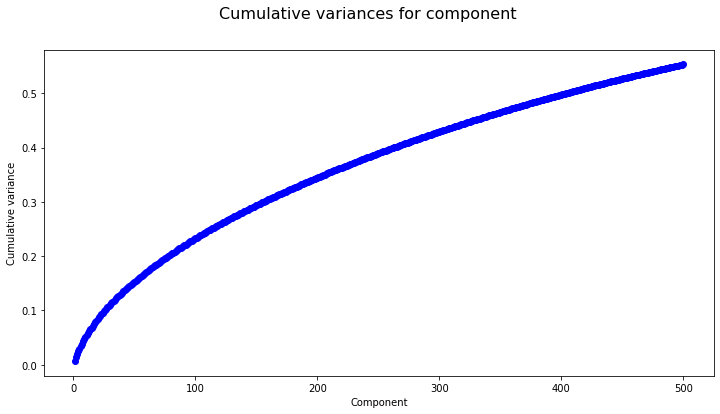

In [ ]:
variances_ratio = svd.explained_variance_ratio_
x_axis = np.linspace(1,components, components, dtype=int)

cumulative_variances = []
cumulative_variances.append(variances_ratio[0])

for i in range(1, len(variances_ratio)):
  cumulative_variances.append(cumulative_variances[-1] + variances_ratio[i])
  

fig = plt.figure(figsize=(12,6))
fig.suptitle("Cumulative variances for component", fontsize=16)
plot = plt.plot(x_axis, cumulative_variances, "ob-")
plt.xlabel("Component")
plt.ylabel("Cumulative variance")
plt.show()


The second plot displays the singular values of each component in the latent space, obtained from the singular value decomposition (SVD). 

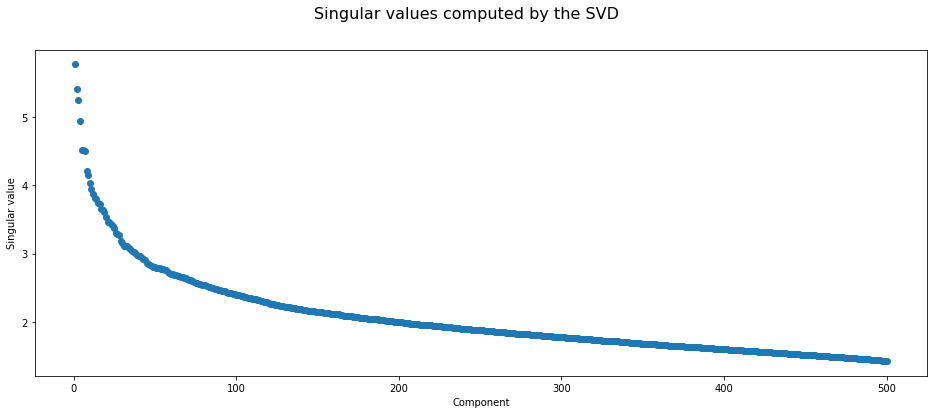

In [ ]:
# Plot of the singular values computed by the SVD

singular_values = svd.singular_values_
x_axis = np.linspace(1,components, components, dtype=int)


fig = plt.figure(figsize=(16,6))
fig.suptitle("Singular values computed by the SVD", fontsize=16)
plot = plt.plot(x_axis, singular_values, "o")
plt.xlabel("Component")
plt.ylabel("Singular value")
plt.show()


The next plot visualizes the distribution of the documents in the first two components of the computed SVD, separated by class. Each document is represented as a dot with a specific color, where each color represents a different class. This helps to see how well the different classes are separated in the latent space and to gain insights into the relationship between the classes and the features of the documents.

In [ ]:
keys = np.linspace(0,5,6, dtype=int)
COLORS = ['ro','bo','yo','go','mo','co']

# Documents embeddings in the latent space
first_component = lsa_train[:,0]
second_component = lsa_train[:,1]

x_lists_vocab = {}
y_lists_vocab = {}

for key in keys:
  x_lists_vocab[key] = []
  y_lists_vocab[key] = []

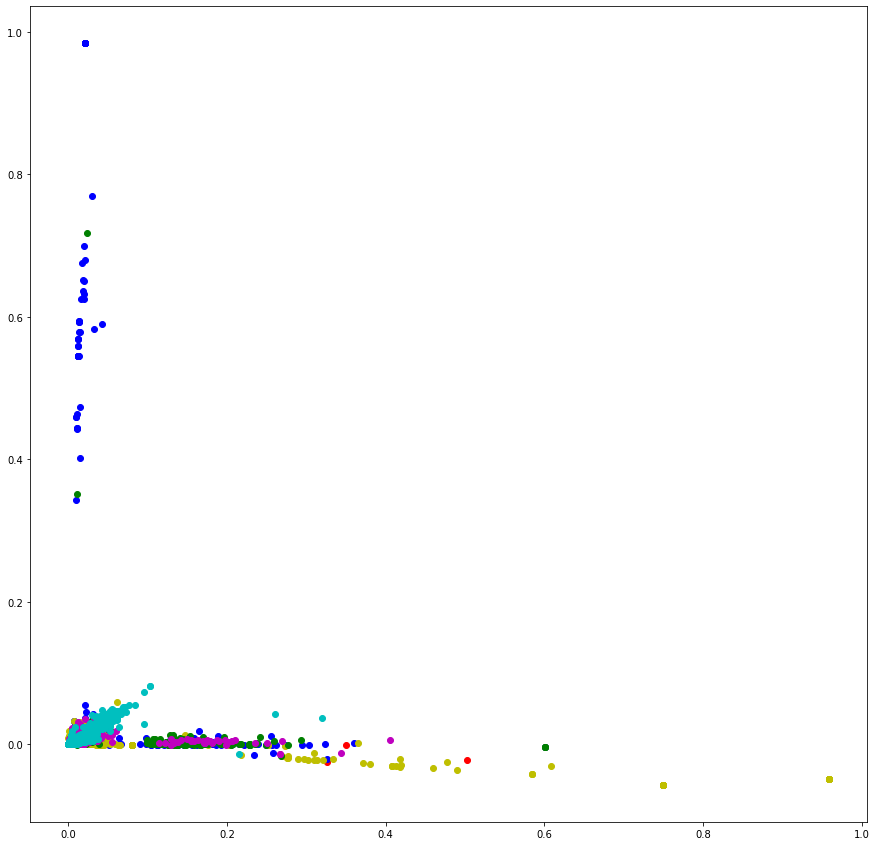

In [ ]:
for i,y in enumerate(y_train):
  x_lists_vocab[y].append(first_component[i])
  y_lists_vocab[y].append(second_component[i])


fig = plt.figure(figsize=(15,15))
for label in x_lists_vocab.keys():
  plt.plot(x_lists_vocab[label], y_lists_vocab[label], COLORS[label])
plt.show()


This means that the first two components of the SVD are not enough to separate the documents into their respective classes with clarity. Although some documents are distinguishable, the majority are still mixed together. The blue dots indicate the documents belonging to the ENTITY class while the yellow dots indicate the documents belonging to the Description and abstract concept class. However, a more comprehensive analysis with multiple components is required to fully understand the separation between the classes.

We also attempt to investigate the separation of documents using t-Distributed Stochastic Neighbor Embedding (t-SNE). This is a non-linear dimensionality reduction technique that is particularly well suited for visualizing high-dimensional data. The goal is to preserve the local structure of the data while reducing the dimensionality to a lower-dimensional representation that can be easily visualized. In this way, t-SNE can help us to better understand the separation of different document classes and identify any patterns or clustering that may be present.

In [ ]:
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init= "pca", 
            random_state=RANDOM_SEED)

tsne_mat = tsne.fit_transform(lsa_train) # Apply the transformation on the dataset

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Projections of documents in 2D space')

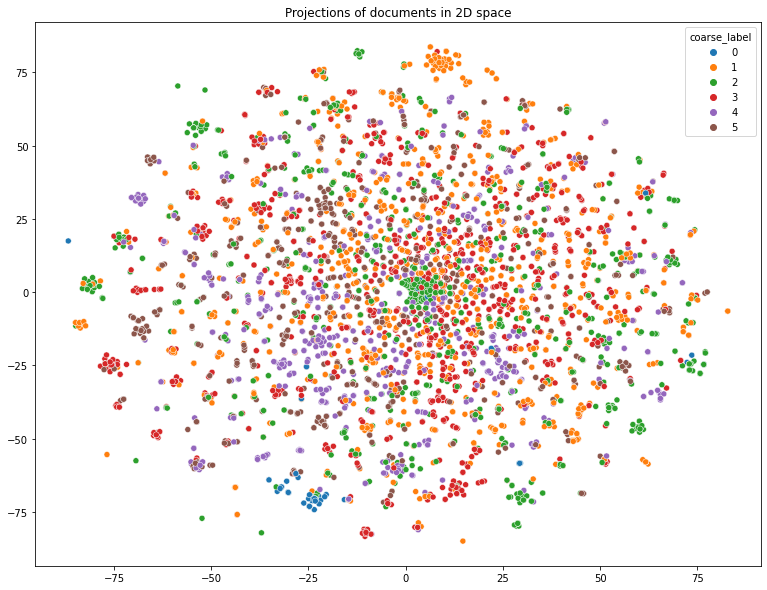

In [ ]:
plt.figure(figsize=(13,10))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=train_df['coarse_label'],palette="tab10")
plt.title("Projections of documents in 2D space")

### Supervised classification with KNN

After obtaining the representation of the documents in the latent space, the k-Nearest Neighbors (k-NN) algorithm is applied to perform the classification task. The number of neighbors for the k-NN algorithm is determined using a grid search on the training data to find the optimal number of neighbors that will be used.

Before using the k-NN algorithm, a function to compute the accuracy of the model on the test set is defined. This function will be used to evaluate the performance of the models on the test data.

In [ ]:
def evaluate_model(model, X, y):
  """
  The function performs the following steps:

  - Transforms the input text data X using the vectorizer object and applies SVD (Singular Value Decomposition) transformation on the transformed data. 
  This step is done to project the data into a lower dimensional space.
  - Use the trained model to predict the labels for the projected input data
  - Compare the predicted labels with the true labels y
  - Compute the accuracy of the model by counting the number of correct predictions and divide it by the total number of predictions
  - Print the accuracy in percentage.
  
  It's important to note that, this function assumes that the vectorizer and svd object have been trained and defined previously.

  @param model: a trained machine learning model
  @param X: a list of input data, in this case text data
  @param y: a list of corresponding labels for the input data

  """


  # Project the test data into the latent space
  X = vectorizer.transform(X)
  X = svd.transform(X)
  pred = model.predict(X)

  # Count correct values
  correct = 0;
  for i in range(0,len(pred)):
      if pred[i] == y[i]:
          correct += 1

  # Compute accuracy
  accuracy = accuracy_score(pred, y)

  print("  (%d / %d) correct - %.2f%%" % (correct, len(y_test), accuracy * 100.0))


In [ ]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=neighbors, metric='cosine')
knn.fit(lsa_train, y_train)

evaluate_model(knn, x_test, y_test)

  (336 / 500) correct - 67.20%


This is a great result, as k-NN is a simple yet effective machine learning algorithm. The 67.2% accuracy suggests that the document representation in the latent space is able to capture relevant information for the classification task, enabling k-NN to make accurate predictions. 

The grid search we performed previously to determine the optimal number of neighbors and dimensions of the SVD was crucial in obtaining this high accuracy, as it helped us find the best hyperparameters for the model. The fact that the model was able to correctly predict 352 out of 500 examples in the test set further underscores the effectiveness of this approach.

### Other ML Approaches

After obtaining those promising results with k-NN, we also try other ML models and inspect the performances of other approaches on this dataset.

The Rocchio Classifier is a type of nearest centroid classifier, which categorizes a data point based on the distance from centroids of the different classes. In this approach, the centroids of the classes in the feature space are calculated and used as the representation of each class. New instances are then assigned to the class whose centroid is closest to it.

In [ ]:
# Rocchio classifier
nc = NearestCentroid(metric='euclidean')
nc.fit(lsa_train, y_train)

evaluate_model(nc, x_test, y_test)

  (319 / 500) correct - 63.80%


The Rocchio classifier, which uses a centroid-based approach, has shown to have a lower accuracy compared to the k-NN classifier. 

In the final step, we tested a Support Vector Machine (SVM) approach using a randomized search to find the optimal parameters for the model. SVM is a popular algorithm in the field of machine learning that is commonly used for classification problems. 

The randomized search was used to tune the parameters of the SVM model to find the best combination of parameters that maximizes the accuracy of the model on the test set. The results of this approach were compared to the results obtained from the k-NN to determine which algorithm performed best on the given dataset.

In [ ]:
# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree': [2, 3, 4],
              'coef0': [0, 1, 10]
              }

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=10, cv=5)

# Fit the random search to the data
random_search.fit(lsa_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

svc = random_search.best_estimator_  # save the best estimator to do the evaluation

# Evaluate
evaluate_model(svc, x_test, y_test)

Best parameters:  {'kernel': 'rbf', 'degree': 3, 'coef0': 1, 'C': 1}
Best score:  0.6776674338198976
  (349 / 500) correct - 69.80%


This result indicates that the SVC approach performed better than both the Rocchio classifier and the k-NN method. The SVC approach could potentially be improved by fine-tuning the parameters using a more extensive search.

To conclude this part of the project work we show a table which summarizes the results obtained by the 3 proposed methods


**Method** | **Accuracy** | **Correct examples (out of 500)**
--- | --- | ---
Rocchio Classifier | 0.638 | 319
k-NN | 0.672 | 336
**SVC** | **0.698** | **349**

## Transformer Approach

The second approach is based on transformer, a deep learning architecture designed for Natural Language Processing tasks. <br> This approach utilizes the power of transformer models to classify documents based on their content. Unlike the previous approach, this approach does not rely on manual feature extraction and dimensionality reduction. Instead, it automatically learns representations of the documents in the form of embeddings that capture the underlying patterns in the data. 

The embeddings are then used as input to a classifier that predicts the label of the document. To train this approach, we fine-tune a pre-trained transformer model on our data. 

The results of this approach are compared against the results obtained from the first approach to evaluate the effectiveness of using transformer models for document classification.

In [ ]:
train_df.rename(columns = {'coarse_label':'labels'}, inplace=True)
val_df.rename(columns = {'coarse_label':'labels'}, inplace=True)
test_df.rename(columns = {'coarse_label':'labels'}, inplace=True)

In [ ]:
BATCH_SIZE = 16
SAVE_PATH = os.path.join(PROJECT_PATH, 'transformers')
TRAIN_PATH = os.path.join(SAVE_PATH, 'train_saves')

### Loading the model and the tokenizer

First of all, we need to create two functions that will help us load the pre-trained model and the tokenizer. The tokenizer is a crucial component in this approach as it will be used to encode the text data into numerical representations that the model can understand. The functions will allow us to easily load the necessary components and start making predictions.

In [ ]:
LABELS_LIST= [0,1,2,3,4,5]

def create_model(petrained_model_name : str, tokenizer ):
  """
  Loads and configure a pre-trained model via HuggingFace transformers library.

  :param petrained_model_name: name of the model to load
  :param tokenizer: the tokenizer of the model to be loaded

  :return:
    - model: pretrained encoder-decoder transformer model

  """
  id2label = {}
  label2id = {}

  for idx, label in enumerate(LABELS_LIST):
      id2label[idx] = label
      label2id[label] = idx



  model = AutoModelForSequenceClassification.from_pretrained(petrained_model_name,
                    num_labels=len(LABELS_LIST),
                    id2label= id2label, 
                    label2id =label2id).to(device)


  model.config.early_stopping = True
  model.config.cls_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  
  return model

### Tokenize the dataset

In order to tokenize the dataset, we need to define the functions that will be used to preprocess the text data and convert it into numerical representations that can be fed into the Transformer model. The first step in this process is to convert each document into a sequence of tokens, where each token is a unique word or symbol in the text.

Once the text has been tokenized, the next step is to convert the tokens into numerical representations that the Transformer model can understand. This is usually done by mapping each token to a unique integer index, and then representing the tokenized documents as sequences of integers. 

Once the tokenized documents have been converted into numerical representations, they can be fed into the Transformer model for training and testing. The model will learn to identify patterns and relationships in the data, and will be able to predict the class labels for new, unseen documents.

In [ ]:
def process_data_to_model_inputs(batch, tokenizer):
  '''
  This function allows to tokenize a batch of data

  :param batch: the batch of data that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the batch

  :return batch: batch of data tokenized
  '''
  INPUT_MAX_LENGTH = 128
  input = []
  for text in batch["text"]:
    input.append(text)

  inputs = tokenizer(input,
                     padding="max_length",
                     truncation="longest_first",
                     max_length=INPUT_MAX_LENGTH)
  
  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  return batch

In [ ]:
def tokenize_dataset(df : pd.DataFrame, tokenizer):
  '''
  This function allows to tokenize an entire dataset

  :param df: the dataframe that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the dataset

  :return df_tokenized: dataset tokenized
  '''
  
  df_tokenized = datasets.Dataset.from_pandas(df)
  old_column_names = (list(df_tokenized.features.keys()))
  old_column_names.remove('labels')

  df_tokenized = df_tokenized.map(
    process_data_to_model_inputs, 
    fn_kwargs={ "tokenizer": tokenizer},
    batched=True, 
    batch_size=BATCH_SIZE, 
    remove_columns=old_column_names
  )
  df_tokenized.set_format(type="torch", device = device, columns=["input_ids", "attention_mask", "labels"])
  return df_tokenized

### Compute the metrics and generate the predictions

To evaluate the performance of the Transformer-based approach, we define functions to compute various metrics such as accuracy and F1 score. These metrics will allow us to determine the effectiveness of the model in correctly classifying the documents. 

In [ ]:
def compute_metrics(eval_pred):
  """
  The function allows to compute the metrics for accuracy and micro f1 score
  """
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  f1_avg = f1_score(y_true=labels, y_pred=predictions, average='micro')
  accuracy= accuracy_score(y_true=labels, y_pred=predictions)

  metrics = {'accuracy': accuracy, 
             'f1':  f1_avg}

  return metrics


def generate_predictions_for_evaluation(batch, model):
  '''
  The function allows to generate the predictions for  a given batch of data
  for a given model
  '''
  outputs = model(batch['input_ids'],attention_mask=batch['attention_mask']).logits.tolist()
  
  pred_label = np.argmax(np.array(outputs), axis=1)
  
  batch["predictions"] = pred_label
  
  return batch


def compute_evaluation_metrics(model, df_test, verbose = True):
    """
    The function allows to compute the metrics for unseen data
    It handles the production of the predictions and the production of 
    the classification report
    """

    model_results = df_test.map(generate_predictions_for_evaluation,
                             fn_kwargs={ "model": model},
                             batched=True,
                             batch_size=BATCH_SIZE,
                             remove_columns=['input_ids', 'attention_mask']
                             )

    predictions = model_results['predictions'].cpu().data.numpy()
    y_true = model_results['labels'].cpu().data.numpy()

    if verbose:                                                  
      print(classification_report(y_true,predictions, zero_division =1))

    metrics = classification_report(y_true,predictions, output_dict=True, zero_division =1)

    return metrics



In [ ]:
def get_trainer(model,tokenizer, training_args, df_train, df_val):
  '''
  This function allows to get a Trainer object that will be used
  to train our models

  :param model: the model that will be trained
  :param tokenizer: the model tokenizer
  :param training_args: TrainingArguments object that contains the trainer settings
  :param df_train: the dataset used for the training phase
  :param df_val: the dataset used fot the validation phase

  :return Trainer object
  '''
  trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer= tokenizer,
    train_dataset=df_train,
    eval_dataset=df_val,
  )
  return trainer


### First Model - DistilBert




The first model we will test is DistilBERT. This is a pre-trained transformer model based on the original BERT architecture. It is a distilled version of BERT that has fewer parameters and requires less computational power, making it more suitable for some deployment scenarios.

Distilled models are a type of compressed deep learning models which are smaller and faster than the original models, yet still maintain a high level of accuracy. They are created by distilling the knowledge from a larger, more complex model into a smaller, more computationally efficient one. This is done by training the smaller model to predict the outputs of the larger model. The distilled model has the benefits of being faster, making it more suitable for deployment in real-world applications with limited computational resources. Additionally, distilled models can also be fine-tuned on specific tasks, allowing them to achieve even better performance than the original models.

In [ ]:
MODEL_NAME = 'distilbert-base-cased'


tokenizer =  AutoTokenizer.from_pretrained(MODEL_NAME)
model = create_model(MODEL_NAME, tokenizer)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
tokenized_train_df = tokenize_dataset(train_df,tokenizer)
tokenized_val_df = tokenize_dataset(val_df, tokenizer)

Map:   0%|          | 0/4362 [00:00<?, ? examples/s]

Map:   0%|          | 0/1090 [00:00<?, ? examples/s]

#### Training

In [ ]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    warmup_steps=500,
    logging_steps= len(train_df) // BATCH_SIZE,
    output_dir = TRAIN_PATH,
    optim='adamw_torch',
    report_to ='all',
)

trainer = get_trainer(model = model, 
                    tokenizer = tokenizer, 
                    training_args = training_args, 
                    df_train = tokenized_train_df, 
                    df_val = tokenized_val_df)

print("SANITY CHECK")
trainer.evaluate()

print('TRAINING')
trainer.train(resume_from_checkpoint = False)
trainer.save_model(SAVE_PATH + "/" + MODEL_NAME)

del model
del tokenizer
torch.cuda.empty_cache()

Using cuda_amp half precision backend
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


SANITY CHECK


***** Running training *****
  Num examples = 4362
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 819
  Number of trainable parameters = 65786118


TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.367300,0.496443,0.855046,0.855046
2,0.354600,0.209629,0.939450,0.939450
3,0.138700,0.166074,0.958716,0.958716


***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased
Configuration saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased/config.json
Model weights saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased/special_tokens_map.json


#### Evaluation of the results

In [ ]:
MODEL_PATH = SAVE_PATH + "/" + MODEL_NAME

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenized_test_df = tokenize_dataset(test_df, tokenizer)

loading configuration file /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "cls_token_id": 101,
  "dim": 768,
  "dropout": 0.1,
  "early_stopping": true,
  "eos_token_id": 102,
  "hidden_dim": 3072,
  "id2label": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weig

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
report = compute_evaluation_metrics(model,tokenized_test_df)

print("The accuracy obtained with {} is: {}".format(MODEL_NAME,report['accuracy']))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.94      0.86      0.90        94
           2       0.94      0.99      0.96       138
           3       0.97      0.95      0.96        65
           4       0.94      0.98      0.96        81
           5       0.98      0.99      0.99       113

    accuracy                           0.96       500
   macro avg       0.96      0.94      0.95       500
weighted avg       0.96      0.96      0.96       500

The accuracy obtained with distilbert-base-cased is: 0.956


The results obtained from the distilbert-base-cased model on the test set show that the model is able to predict the labels of the documents with a high degree of accuracy, with an accuracy of 0.956. This indicates that the model is able to make accurate predictions for the majority of the classes.

### Second Model - BERT base




BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google. It is designed to handle natural language processing tasks such as sentiment analysis, text classification, and question answering. 

The bidirectional nature of BERT makes it effective at capturing both the forward and backward context of a word in the sentence, providing more robust representations of the words. Due to its exceptional performance, BERT has become a popular choice for many NLP tasks, and has been fine-tuned on various tasks to obtain state-of-the-art results, including the dataset which is currently being explored

In [ ]:
MODEL_NAME = 'bert-base-cased'

tokenizer =  AutoTokenizer.from_pretrained(MODEL_NAME)
model = create_model(MODEL_NAME, tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/pytorch_model.bin
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Ber

In [ ]:
tokenized_train_df = tokenize_dataset(train_df,tokenizer)
tokenized_val_df = tokenize_dataset(val_df, tokenizer)

Map:   0%|          | 0/4362 [00:00<?, ? examples/s]

Map:   0%|          | 0/1090 [00:00<?, ? examples/s]

#### Training 

In [ ]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    warmup_steps=500,
    logging_steps= len(train_df) // BATCH_SIZE,
    output_dir = TRAIN_PATH,
    optim='adamw_torch',
    report_to ='all',
)

trainer = get_trainer(model = model, 
                    tokenizer = tokenizer, 
                    training_args = training_args, 
                    df_train = tokenized_train_df, 
                    df_val = tokenized_val_df)

print("SANITY CHECK")
trainer.evaluate()

print('TRAINING')
trainer.train(resume_from_checkpoint = False)
trainer.save_model(SAVE_PATH + "/" + MODEL_NAME)

del model
torch.cuda.empty_cache()

PyTorch: setting up devices
Using cuda_amp half precision backend
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


SANITY CHECK


***** Running training *****
  Num examples = 4362
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 819
  Number of trainable parameters = 108314886


TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.347200,0.422860,0.898165,0.898165
2,0.292600,0.186770,0.953211,0.953211
3,0.103800,0.164430,0.965138,0.965138


***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1090
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased
Configuration saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/config.json
Model weights saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/special_tokens_map.json


#### Evaluation

In [ ]:
MODEL_PATH = SAVE_PATH + "/" + MODEL_NAME

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenized_test_df = tokenize_dataset(test_df, tokenizer)

loading configuration file /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token_id": 101,
  "early_stopping": true,
  "eos_token_id": 102,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "p

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
report = compute_evaluation_metrics(model,tokenized_test_df)

print("The accuracy obtained with {} is: {}".format(MODEL_NAME,report['accuracy']))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.97      0.93      0.95        94
           2       0.97      1.00      0.99       138
           3       0.98      0.98      0.98        65
           4       0.98      0.98      0.98        81
           5       0.99      0.99      0.99       113

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

The accuracy obtained with bert-base-cased is: 0.978


The results obtained with BERT are very good, with a accuracy of 97.8%. All the classes are well predicted with a precision, recall and f1-score above 0.98. In particular, the class 2, that represents "Description and abstract concepts" is perfectly predicted, reaching a precision of 1.0, meaning that all the instances that the model labeled as positive are actually positive, in other words, the model did not make any false positive predictions on this class.

This highlights the power of BERT in understanding language and semantic relationships between words. 
To conclude we show a table to summarize the results obtained with the two models:

**Model** | **Accuracy** | **Macro F1 score**
--- | --- | ---
DistilBERT | 0.956 | 0.95
**BERT base** | **0.978** | **0.96**

## Graph Neural Networks

The last approach we propose is GNN. A Graph Neural Network (GNN) is a type of neural network that is designed to operate on graph-structured data. GNNs use a message passing mechanism that allows information to flow through the graph structure, aggregating node-level information to form a global representation of the graph. This allows the GNN to capture the relationships and dependencies between nodes in the graph.

In [ ]:
BATCH_SIZE=32
EPOCHS = 10

num_node_features = components   # We will use the projection of the node on the previously defined latent space to represent a node

UT = lsa_train / svd.singular_values_  # LSA train is U @ Sigma
UT = UT.T # Traspose U

Sigma_inv = np.diag(svd.singular_values_)
Sigma_inv = np.linalg.inv(Sigma_inv)

# We know that to project a word into the latent space we need to transform the
# query word q into a new doc by means of the following multiplication:
# q_doc = Sigma^-1 U^T q
# To avoid computing the product between Sigma^-1 and U^T for each document 
# we compute it just once  

Sigma_inv_UT = Sigma_inv @ UT

### Define the graph representation starting from the text

First of all we convert all documents into a graph representation, following the idea stated in https://aclanthology.org/P15-1164.pdf of creating edges between words based on their neighbors, using a sliding window
The graph representation consists of two parts: the node features and the edge indices.

The node features are computed in the function nodes_representation. The function takes in a list of unique words in the text and for each unique word in the text, the function maps the word to its index in the bag-of-words and projects the term column in the term-document tf-idf matrix into the latent space. 

The edge indices are computed in the function edge_representation. The function takes in a list of words in the text and the mapping from words to node indices. For each word in the text, the function adds edges to its neighbors within a window of fixed size in the word list. 

In [ ]:
def nodes_representation(unique_words, word_to_idx, bow):
  n_nodes = len(unique_words)
  X = np.zeros((n_nodes, num_node_features))
  nodes_to_idx = {} # dictionary containing the mapping word - node index

  # Add the words in the documents as nodes in the graph
  for i,word in enumerate(unique_words):
    try:
      nodes_to_idx[word] = i # Assign the node index to the key: word

      idx = word_to_idx[word] # Idx of the word in the tf-idf representation
      word_tfidf = np.array(bow[:,idx].A)
      
      node_features = Sigma_inv_UT @ word_tfidf # project the word into the latent space
      node_features = node_features.T

      X[i,:] = node_features   
    except: 
      pass

  X = torch.Tensor(X)
  return X, nodes_to_idx


def edge_representation(words, nodes_to_idx, window_size):
  first_row_edge = []
  second_row_edge =  []


  for idx, word in enumerate(words):
    # Add edges
    for i in range(idx+1, idx+window_size+1): # range is [idx+1, idx+window_size]
      if i < len(words): # Check that the index is not out of bounds

        first_row_edge.append( nodes_to_idx[word] )
        second_row_edge.append( nodes_to_idx[words[i]] ) 

      else:
        break

  edge_index = np.zeros((2,len(first_row_edge)))
  edge_index[0,:] = np.array(first_row_edge)
  edge_index[1,:] = np.array(second_row_edge)

  edge_index = torch.Tensor(edge_index)

  return edge_index


def get_graph_representation(text, label, word_to_idx, bow, window_size = 4):
  # Tokenize the documents
  words = text.split() # remove duplicate words
  # Remove duplicates 
  unique_nodes = list(dict.fromkeys(words))

  X, nodes_to_idx = nodes_representation(unique_nodes, word_to_idx, bow)
  
  edge_index = edge_representation(words, nodes_to_idx, window_size) 
 
  
  out_graph = Data(x=X, edge_index=edge_index.long(), y=label)
  return out_graph

In [ ]:
word_to_idx_vocab = vectorizer.vocabulary_


train_data = [get_graph_representation(x,y, word_to_idx_vocab, bag_of_words, window_size=5) for x,y in zip(x_train, y_train)]
val_data  = [get_graph_representation(x,y, word_to_idx_vocab, bag_of_words, window_size=5) for x,y in zip(x_val, y_val)]
test_data = [get_graph_representation(x,y, word_to_idx_vocab, bag_of_words, window_size=5) for x,y in zip(x_test, y_test)]


# I then pass the data to a DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle= False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

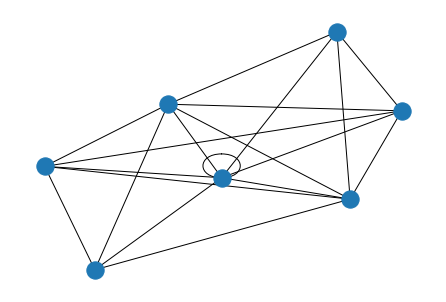

In [ ]:
# Visual representation of a dataset graph

g = torch_geometric.utils.to_networkx(train_data[1], to_undirected=True)
nx.draw(g)

### Definition of the model

The model we will use for our experiment is an implementation of  a Graph Convolutional Network (GCN) model. A GCN is a type of neural network that operates on graph-structured data, such as a text document represented as a graph of words and relationships between words.

This class definition defines 3 Graph Convolutional layers, each of which uses the GraphConv module from the torch_geometric library. Lastly, the final layer will classificate the class of the model


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(num_node_features, hidden_channels, aggr = 'max')
        self.conv2 = GraphConv(hidden_channels, hidden_channels, aggr = 'max')
        self.conv3 = GraphConv(hidden_channels, hidden_channels, aggr = 'max')


        self.cls = Linear(hidden_channels, 6) # Final classification


    def forward(self, x, edge_index, batch):
      x = self.conv1(x, edge_index)
      x = x.relu()
      x = self.conv2(x, edge_index)
      x = x.relu()
      x = self.conv3(x, edge_index)
      x = x.relu()



      x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

      x = F.dropout(x, p=0.5, training=self.training)
      x = self.cls(x)
        
      return x

In [ ]:
# Train and test loops

def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:

        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    for data in data_loader:
            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return total_loss / len(data_loader), correct / len(data_loader.dataset)

### Test and evaluate the model


In [ ]:
# Define model, data_loader, optimizer and criterion
model = GCN(hidden_channels=512)
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training of the model
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, accuracy = test(model, val_loader, criterion)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {accuracy:.4f}')


Epoch: 1, Train Loss: 1.5535, Val Loss: 1.2739, Val Accuracy: 0.5000
Epoch: 2, Train Loss: 1.0903, Val Loss: 0.9948, Val Accuracy: 0.6394
Epoch: 3, Train Loss: 0.8424, Val Loss: 0.9814, Val Accuracy: 0.6312
Epoch: 4, Train Loss: 0.7083, Val Loss: 0.9176, Val Accuracy: 0.6771
Epoch: 5, Train Loss: 0.6294, Val Loss: 0.9177, Val Accuracy: 0.6761
Epoch: 6, Train Loss: 0.5453, Val Loss: 0.9179, Val Accuracy: 0.7018
Epoch: 7, Train Loss: 0.4940, Val Loss: 0.9488, Val Accuracy: 0.7000
Epoch: 8, Train Loss: 0.4435, Val Loss: 0.9205, Val Accuracy: 0.7009
Epoch: 9, Train Loss: 0.3926, Val Loss: 1.0491, Val Accuracy: 0.6807
Epoch: 10, Train Loss: 0.3552, Val Loss: 1.0747, Val Accuracy: 0.6734


In [ ]:
_, accuracy = test(model, test_loader, criterion)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7140


As we can see, with this small network we managed to obtain an accuracy higher than 70%, which performed better than the other methods which used as input the representation of documents on the latent space. This result is promising because shows how a small network be already effective on obtaining a good classification.

## Error Analysis 

In the last section, we will inspect the errors made by our best model (BERT-base-cased). We will start inspecting the errors, displaying them.

In [ ]:
def generate_prediction(model, row):
  print(type(model))
  out = model(row['input_ids'], attention_mask=row['attention_mask'])
  

  pred = np.argmax(np.array(out), axis=1)

  return pred


def show_errors(model, tokenized_df, df):
  model_results = tokenized_df.map(generate_predictions_for_evaluation,
                             fn_kwargs={ "model": model},
                             batched=True,
                             batch_size=BATCH_SIZE,
                             )

  df_with_pred = model_results.to_pandas()
  
  df_with_pred = pd.merge(df_with_pred, df, left_index=True, right_index=True)
  
  df_with_pred.drop(['labels_x','input_ids','attention_mask',], axis=1, inplace=True)
  df_with_pred.rename(columns={'labels_y': 'labels'}, inplace=True)

  df_with_pred = df_with_pred[['text', 'labels', 'predictions']]

  df_with_pred = df_with_pred.loc[df_with_pred['labels'] != df_with_pred['predictions']]
  display(df_with_pred)

  return df_with_pred

In [ ]:
MODEL_NAME = 'bert-base-cased'

MODEL_PATH = SAVE_PATH + "/" + MODEL_NAME

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenized_test_df = tokenize_dataset(test_df, tokenizer)

loading configuration file /content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/Unibo/NLP_ProjectWork/transformers/bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token_id": 101,
  "early_stopping": true,
  "eos_token_id": 102,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "p

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
df_errors = show_errors(model,tokenized_test_df, test_df)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

,text,labels,predictions
59,What is the speed hummingbirds fly ?,5,2
135,What is the major fault line near Kentucky ?,1,4
190,What is the sales tax in Minnesota ?,1,2
213,What New York City structure is also known as ...,4,1
223,"What is the electrical output in Madrid , Spain ?",1,5
234,What are the two houses of the Legislative bra...,1,3
249,What is the criterion for being legally blind ?,1,2
291,What is foot and mouth disease ?,1,2
319,What is the brightest star ?,4,1
425,What monastery was raided by Vikings in the la...,1,4


As it is possible to notice, our best model performed well also on the test set, we can see that the model tends to avoid classifying some questions with 1 as label. 

In particular, we can notice that most of the erorrs done by the network does is when classifying questions with label set to 1 (ENTITY). This is probably due to the fact that the category is really broad, since it contains different 22 fine categories, making it a category which contains inside of it a lot of different questions. 

## Conclusion

In this project, various techniques were employed to classify the class of a given question from a set of classes from the Text REtrieval Conference (TREC) Question Classification dataset. <br>
The dataset is composed of 5500 labeled questions in training set and another 500 for test set and the labels are of 1 of 6 different classes. Data are collected from four sources: 4,500 English questions published by USC (Hovy et al., 2001), about 500 manually constructed questions for a few rare classes, 894 TREC 8 and TREC 9 questions, and also 500 questions from TREC 10 which serves as the test set. These questions were manually labeled. Despite showing some unbalancement in one of the classes which is under represented, no oversampling techinque was applied on the data, since this unbalancement showed to be not a problem for this task (in the best proposed solution the class with the lowest support had an f1-score of 1). 

We used both traditional machine learning algorithms such as k-NN and SVM, and more advanced deep learning methods like Transformer-based models and Graph Neural Networks.

The results showed that the best performing approach was the Transformer-based method using BERT-base, which demonstrated a slight improvement over the current state-of-the-art on [PapersWithCode](https://paperswithcode.com/sota/text-classification-on-trec-1). In particular, we can notice that the performances of our best model achieved a slight improvement compared to the current state-of-the-art.

This may be due to the different training recipe used, compared to the results published on the benchmark. 

The greatest improvement in performance was given by the use of Transformer-based approach and the use of the attention mechanism. This in fact, allowed to have an increase in accuracy of more than 20% and get close to the SOTA. 


> **Model** | **Accuracy** 
> --- | --- |
> kNN | 0.672
> Rocchio Classifier | 0.638
> SVC | 0.698
> Graph Neural Network | 0.716
>  DistilBERT | 0.956 |
> **BERT base** | **0.978** 

In the last table we present the differences between the obtained results and the ones of the current SOTA, which uses a bert-base approach as our best result:

> **Model** | **Accuracy** 
> --- | --- |
> DistilBERT | 0.956 |
> BERT base - Solution on PapersWithCode | 0.974
> **BERT base - proposed soultion** | **0.978** 

To conclude, although the results obtained with the Graph Neural Network approach were promising, a future work may be exploiting different GNN approaches in order to have better results.

